**Step 1: Load and Explore the Data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure plotting defaults
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

# Load the dataset
file_path = 'purchases.txt'
try:
    data = pd.read_csv(file_path, sep='\t', header=None, names=['customer_id', 'purchase_amount', 'date_of_purchase'])
    data['date_of_purchase'] = pd.to_datetime(data['date_of_purchase'])
    data['year_of_purchase'] = data['date_of_purchase'].dt.year
except FileNotFoundError:
    print(f"Error: '{file_path}' not found. Please provide the correct file path.")
    data = None

# Check for missing values
if data is not None:
    missing_values = data.isnull().sum()
    print("Missing values per column:\n", missing_values)

# Display the first few rows of the dataset
print("\nFirst few rows of the DataFrame:")
print(data.head())
print(data.describe())


Missing values per column:
 customer_id         0
purchase_amount     0
date_of_purchase    0
year_of_purchase    0
dtype: int64

First few rows of the DataFrame:
   customer_id  purchase_amount date_of_purchase  year_of_purchase
0          760             25.0       2009-11-06              2009
1          860             50.0       2012-09-28              2012
2         1200            100.0       2005-10-25              2005
3         1420             50.0       2009-07-09              2009
4         1940             70.0       2013-01-25              2013
         customer_id  purchase_amount               date_of_purchase  \
count   51243.000000     51243.000000                          51243   
mean   108934.547938        62.337195  2011-07-14 01:27:23.721093632   
min        10.000000         5.000000            2005-01-02 00:00:00   
25%     57720.000000        25.000000            2009-01-17 00:00:00   
50%    102440.000000        30.000000            2011-11-23 00:00:00   
75%


**Step 2: Compute Recency, Frequency, and Monetary Value**


First few rows of the customers DataFrame:
   customer_id  recency  frequency      amount
0           10     3829          1   30.000000
1           80      343          7   71.428571
2           90      758         10  115.800000
3          120     1401          1   20.000000
4          130     2970          2   50.000000
         customer_id       recency     frequency        amount
count   18417.000000  18417.000000  18417.000000  18417.000000
mean   137573.510887   1253.037900      2.782375     57.792985
std     69504.599881   1081.437868      2.936888    154.360109
min        10.000000      1.000000      1.000000      5.000000
25%     81990.000000    244.000000      1.000000     21.666667
50%    136430.000000   1070.000000      2.000000     30.000000
75%    195100.000000   2130.000000      3.000000     50.000000
max    264200.000000   4014.000000     45.000000   4500.000000


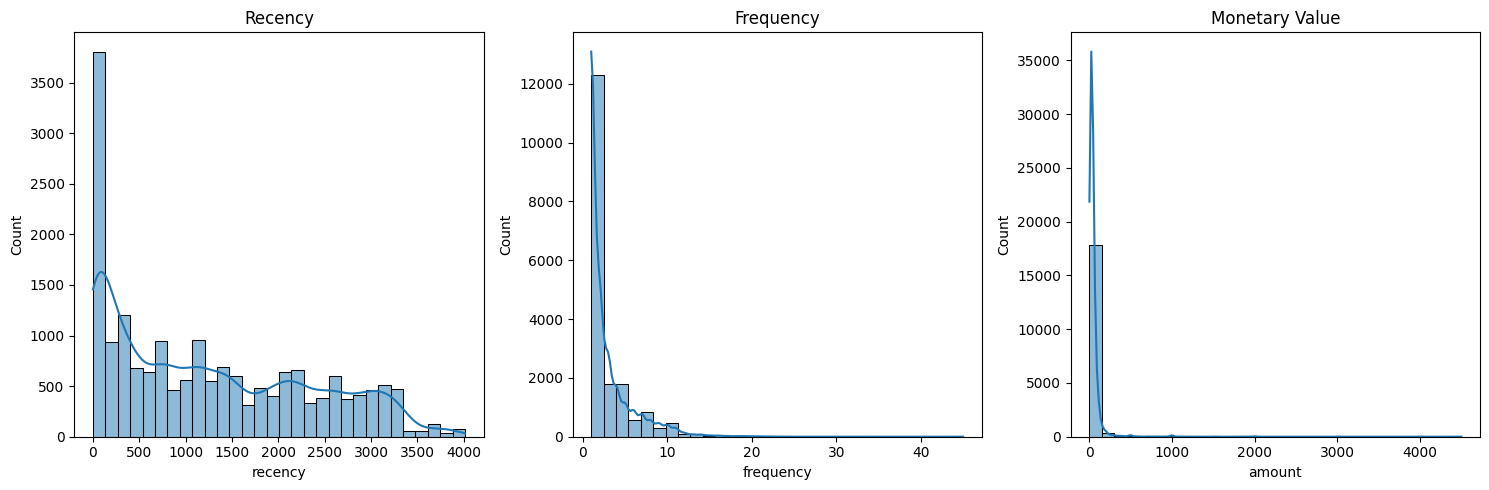

In [ ]:
# Define the reference date
reference_date = datetime(2016, 1, 1)

# Calculate days since the reference date
data['days_since'] = (reference_date - data['date_of_purchase']).dt.days

# Compute key marketing indicators
customers = data.groupby('customer_id').agg(
    recency=('days_since', 'min'),
    frequency=('customer_id', 'count'),
    amount=('purchase_amount', 'mean')
).reset_index()


# Display the first few rows of the customers dataset
print("\nFirst few rows of the customers DataFrame:")
print(customers.head())
print(customers.describe())

# Plot histograms
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(customers['recency'], bins=30, kde=True)
plt.title('Recency')

plt.subplot(1, 3, 2)
sns.histplot(customers['frequency'], bins=30, kde=True)
plt.title('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(customers['amount'], bins=30, kde=True)
plt.title('Monetary Value')

plt.tight_layout()
plt.show()


**Step 3: Segment Customers Based on RFM Scores**

In [ ]:
# Define scoring function for Recency
def score_recency(x, d):
    if x <= d['recency'][0.25]:
        return 3
    elif x <= d['recency'][0.50]:
        return 2
    else:
        return 1

# Define scoring function for Frequency and Monetary Value
def score_fm(x, d, metric):
    if x >= d[metric][0.75]:
        return 3
    elif x >= d[metric][0.50]:
        return 2
    else:
        return 1

# Calculate quantiles for scoring
quantiles = customers.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

# Apply scoring functions
customers['R_score'] = customers['recency'].apply(score_recency, args=(quantiles,))
customers['F_score'] = customers['frequency'].apply(score_fm, args=(quantiles, 'frequency'))
customers['M_score'] = customers['amount'].apply(score_fm, args=(quantiles, 'amount'))

# Combine RFM scores
customers['RFM_score'] = customers['R_score'].astype(str) + customers['F_score'].astype(str) + customers['M_score'].astype(str)

# Display the first few rows of the customers dataset with RFM scores
print("\nFirst few rows of the customers DataFrame with RFM scores:")
print(customers.head())



First few rows of the customers DataFrame with RFM scores:
   customer_id  recency  frequency      amount  R_score  F_score  M_score  \
0           10     3829          1   30.000000        1        1        2   
1           80      343          7   71.428571        2        3        3   
2           90      758         10  115.800000        2        3        3   
3          120     1401          1   20.000000        1        1        1   
4          130     2970          2   50.000000        1        2        3   

  RFM_score  
0       112  
1       233  
2       233  
3       111  
4       123  


**Step 4: Define Segments and Suggest Marketing Actions**


First few rows of the customers DataFrame with segments:
   customer_id  recency  frequency      amount  R_score  F_score  M_score  \
0           10     3829          1   30.000000        1        1        2   
1           80      343          7   71.428571        2        3        3   
2           90      758         10  115.800000        2        3        3   
3          120     1401          1   20.000000        1        1        1   
4          130     2970          2   50.000000        1        2        3   

  RFM_score         segment  
0       112             NaN  
1       233       Promising  
2       233       Promising  
3       111             NaN  
4       123  About to Sleep  

Segment counts:
segment
About to Sleep          405
At Risk                 613
Cannot Lose             319
Champions              1095
Hibernating             480
Loyal Customers         912
Need Attention          260
Potential Loyalists     244
Promising               591
Name: count, dtype: in

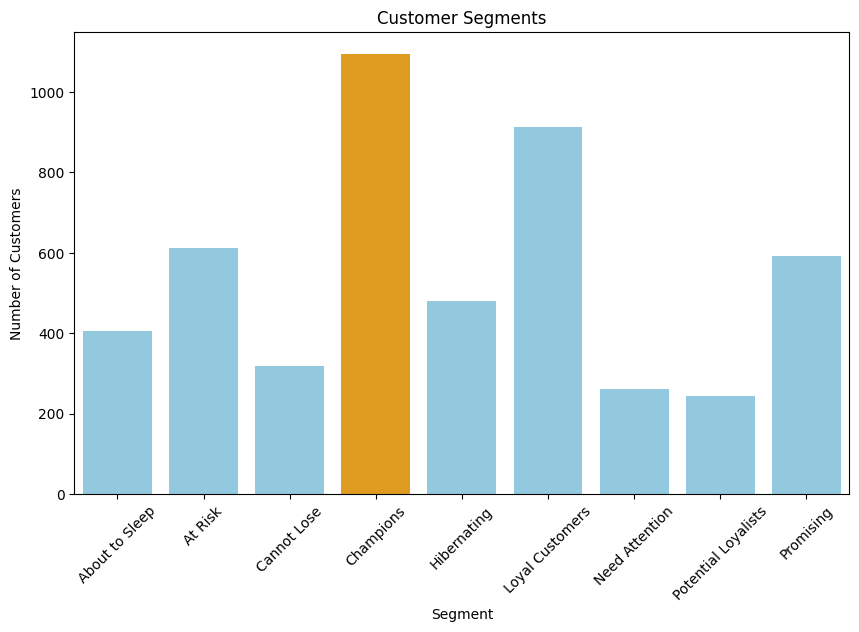

In [ ]:
# Define segments
segments = {
    '333': 'Champions',
    '332': 'Loyal Customers',
    '323': 'Potential Loyalists',
    '233': 'Promising',
    '223': 'Need Attention',
    '232': 'At Risk',
    '222': 'Cannot Lose',
    '133': 'Hibernating',
    '123': 'About to Sleep'
}

# Map RFM scores to segments
customers['segment'] = customers['RFM_score'].map(segments)

# Display the first few rows of the customers dataset with segments
print("\nFirst few rows of the customers DataFrame with segments:")
print(customers.head())

# Count the number of customers in each segment and calculate mean values
segment_counts = customers['segment'].value_counts().sort_index()
segment_stats = customers.groupby('segment').agg(
    Average_Recency=('recency', 'mean'),
    Average_Frequency=('frequency', 'mean'),
    Average_Monetary=('amount', 'mean')
).reset_index()

# Print segment counts
print("\nSegment counts:")
print(segment_counts)

# Print segment statistics
print("\nSegment statistics:")
print(segment_stats)


# Plot the segment sizes
plt.figure(figsize=(10, 6))

# Get the segment with the highest count
max_segment = segment_counts.idxmax()

# Create a color palette with a different color for the highest segment
colors = ['skyblue' if segment != max_segment else 'orange' for segment in segment_counts.index]

# Plot the barplot with custom colors
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette=colors)

plt.title('Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()



**Step 5: Select the Two Most Important Segments and Suggest Marketing Actions**



In [ ]:
# Select the two most important segments
top_segments = segment_counts.nlargest(2).index
print(f"\nThe two most important segments are: {top_segments}")

# Suggest marketing actions
marketing_actions = {
    'Champions': 'Offer exclusive discounts and early access to new products.',
    'Loyal Customers': 'Provide personalized recommendations and loyalty rewards.'
}

# Display marketing actions for the top segments
for segment in top_segments:
    print(f"\nSegment: {segment}")
    print(f"Marketing Action: {marketing_actions.get(segment, 'No specific action suggested.')}")
    print()



The two most important segments are: Index(['Champions', 'Loyal Customers'], dtype='object', name='segment')

Segment: Champions
Marketing Action: Offer exclusive discounts and early access to new products.


Segment: Loyal Customers
Marketing Action: Provide personalized recommendations and loyalty rewards.

